# Recurrent Neural Network (RNN) for SMS Spam Detection

This notebook trains and evaluates an RNN model with word embeddings for SMS spam detection

Experiments:
- RNN with TF-IDF
- RNN with Word2Vec Skip-gram
- RNN with Word2Vec CBOW

Dataset: SMS Spam Collection
Metrics: Accuracy, Precision, Recall, F1-Score

1: Install Required Packages

In [5]:
# Install required packages
!pip install gensim tensorflow scikit-learn pandas numpy matplotlib seaborn nltk wordcloud

# Download NLTK data
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

print("Setup complete!")


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...


Setup complete!


[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


2: Imports and Configuration

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import time
import warnings
import urllib.request
import zipfile
import os
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, classification_report, confusion_matrix,
                            roc_curve, auc)
from sklearn.preprocessing import LabelEncoder

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Embedding, LSTM, Dense, Dropout,
                                    Bidirectional, BatchNormalization)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Gensim for Word2Vec
from gensim.models import Word2Vec

# NLTK imports
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"TensorFlow version: {tf.__version__}")
print("All imports successful!")

TensorFlow version: 2.20.0
All imports successful!


3: Download and Load Dataset

In [8]:
print("Downloading SMS Spam Collection dataset...")

# Dataset URL and paths
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_filename = "sms_spam_collection.zip"
extract_folder = "sms_data"
data_file = os.path.join(extract_folder, "SMSSpamCollection")

# Check if already downloaded
if os.path.exists(data_file):
    print(" Dataset already exists, loading...")
else:
    print("Downloading from UCI repository...")
    print(f"   URL: {url}")
    
    try:
        # Download ZIP file
        urllib.request.urlretrieve(url, zip_filename)
        print(f" Downloaded: {zip_filename}")
        
        # Extract ZIP file
        print(f"Extracting to: {extract_folder}/")
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)
        print("Extraction complete")
        
        # Clean up ZIP file (optional)
        os.remove(zip_filename)
        print(f"Cleaned up: {zip_filename}")
        
    except Exception as e:
        print(f"\n Download failed: {e}")
        print("\nPlease check your internet connection or try manual download:")
        print("https://archive.ics.uci.edu/dataset/228/sms+spam+collection")
        raise

# Load the dataset
print("\n Loading dataset...")
df = pd.read_csv(data_file, sep='\t', header=None, names=['label', 'text'])

print("DATASET LOADED SUCCESSFULLY")
print("-" * 70)
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\n Class Distribution:")
print(df['label'].value_counts())
print(f"\n Percentages:")
print(df['label'].value_counts(normalize=True).round(4) * 100)
print(f"\n First 5 samples:")
print(df.head().to_string())

 Dataset already exists, loading...

 Loading dataset...
DATASET LOADED SUCCESSFULLY
----------------------------------------------------------------------
Shape: 5572 rows × 2 columns

 Class Distribution:
label
ham     4825
spam     747
Name: count, dtype: int64

 Percentages:
label
ham     86.59
spam    13.41
Name: proportion, dtype: float64

 First 5 samples:
  label                                                                                                                                                         text
0   ham                                              Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1   ham                                                                                                                                Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's 

4: Exploratory Data Analysis (EDA)

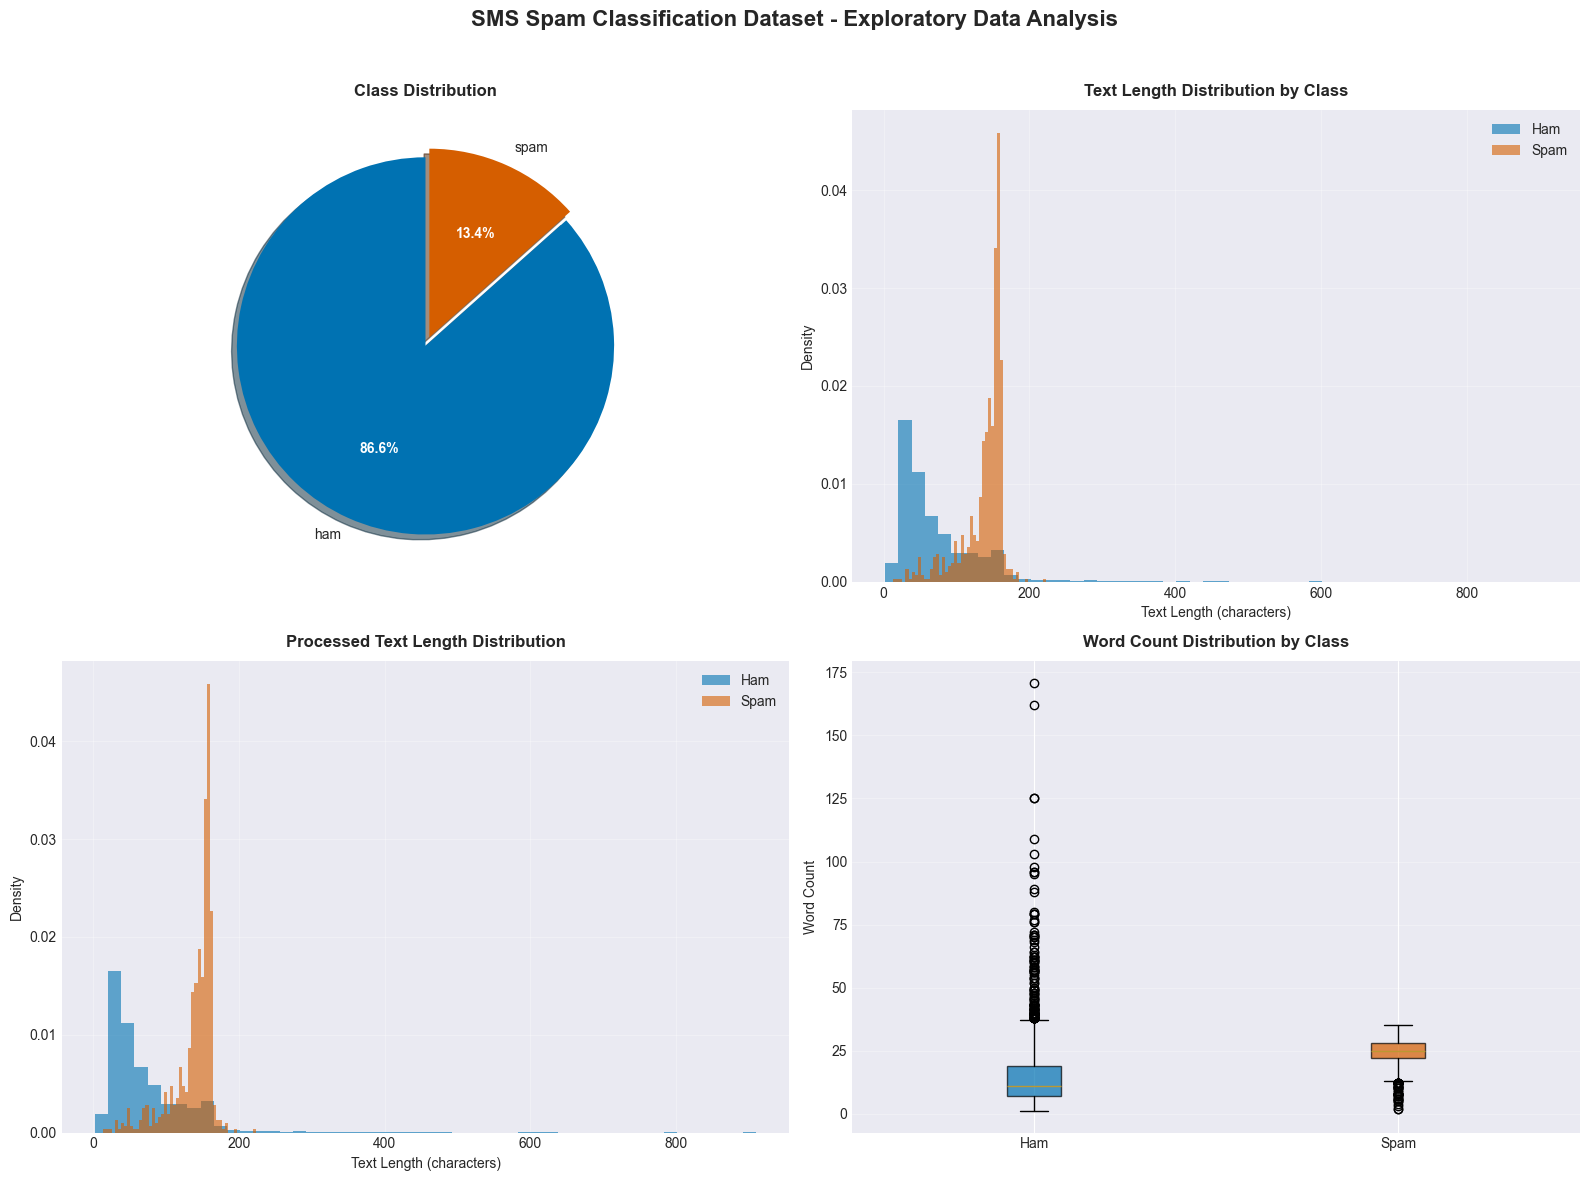

In [9]:
# Calculate text statistics
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df['avg_word_length'] = df['text'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)

# figure with 2x2 layout 
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('SMS Spam Classification Dataset - Exploratory Data Analysis',
             fontsize=16, fontweight='bold', y=0.98)
colors = {'ham': '#0072B2', 'spam': '#D55E00'}  

# 1. Pie Chart - Class Distribution
ax1 = axes[0, 0]
class_counts = df['label'].value_counts()
wedges, texts, autotexts = ax1.pie(class_counts.values,
                                    labels=class_counts.index,
                                    autopct='%1.1f%%',
                                    colors=[colors['ham'], colors['spam']],
                                    explode=(0, 0.05),
                                    shadow=True,
                                    startangle=90)
ax1.set_title('Class Distribution', fontsize=12, fontweight='bold', pad=10)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# 2. Histogram - Text Length Distribution by Class
ax2 = axes[0, 1]
for label in ['ham', 'spam']:
    subset = df[df['label'] == label]
    ax2.hist(subset['text_length'], bins=50, alpha=0.6,
             label=label.capitalize(), color=colors[label], density=True)
ax2.set_xlabel('Text Length (characters)', fontsize=10)
ax2.set_ylabel('Density', fontsize=10)
ax2.set_title('Text Length Distribution by Class', fontsize=12, fontweight='bold', pad=10)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Histogram - Processed Text Length Distribution
ax3 = axes[1, 0]
ax3.hist(df[df['label'] == 'ham']['text_length'], bins=50, alpha=0.6,
         label='Ham', color=colors['ham'], density=True)
ax3.hist(df[df['label'] == 'spam']['text_length'], bins=50, alpha=0.6,
         label='Spam', color=colors['spam'], density=True)
ax3.set_xlabel('Text Length (characters)', fontsize=10)
ax3.set_ylabel('Density', fontsize=10)
ax3.set_title('Processed Text Length Distribution', fontsize=12, fontweight='bold', pad=10)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Box Plot - Word Count Distribution by Class (Bottom Right)
ax4 = axes[1, 1]
data_to_plot = [df[df['label'] == 'ham']['word_count'],
                df[df['label'] == 'spam']['word_count']]
bp = ax4.boxplot(data_to_plot, labels=['Ham', 'Spam'], patch_artist=True)
bp['boxes'][0].set_facecolor(colors['ham'])
bp['boxes'][1].set_facecolor(colors['spam'])
bp['boxes'][0].set_alpha(0.7)
bp['boxes'][1].set_alpha(0.7)
ax4.set_ylabel('Word Count', fontsize=10)
ax4.set_title('Word Count Distribution by Class', fontsize=12, fontweight='bold', pad=10)
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('eda_overview.png', dpi=300, bbox_inches='tight')
plt.show()

5: Additional EDA - Word Clouds and N-grams

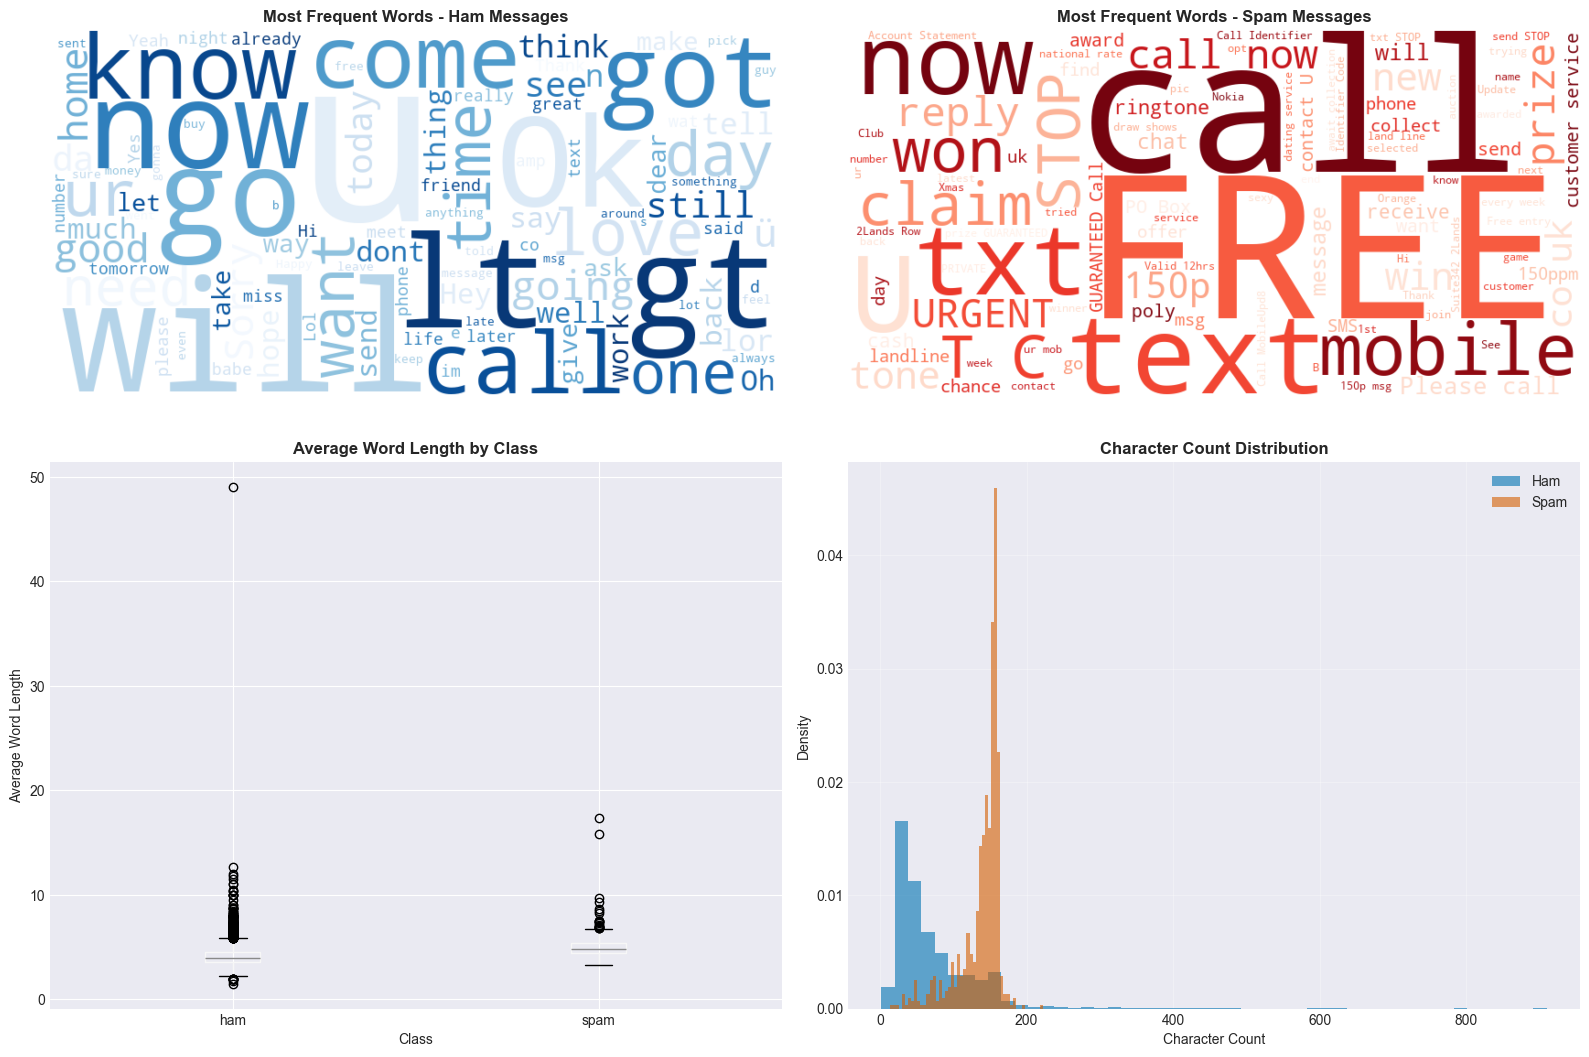


 DETAILED STATISTICS:
      text_length                                                           \
            count        mean        std   min    25%    50%    75%    max   
label                                                                        
ham        4825.0   71.482487  58.440652   2.0   33.0   52.0   93.0  910.0   
spam        747.0  138.670683  28.873603  13.0  133.0  149.0  157.0  223.0   

      word_count             ...              avg_word_length            \
           count       mean  ...   75%    max           count      mean   
label                        ...                                          
ham       4825.0  14.310259  ...  19.0  171.0          4825.0  4.167577   
spam       747.0  23.911647  ...  28.0   35.0           747.0  4.968667   

                                                               
            std       min  25%       50%       75%        max  
label                                                          
ham    1.126890  1

In [10]:
# WORD CLOUDS AND N-GRAMS

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('SMS Spam Classification - Text Analysis',
             fontsize=16, fontweight='bold', y=0.98)

# 1. Word Cloud - Ham Messages
ax1 = axes[0, 0]
ham_text = ' '.join(df[df['label'] == 'ham']['text'])
ham_wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          colormap='Blues',
                          max_words=100).generate(ham_text)
ax1.imshow(ham_wordcloud, interpolation='bilinear')
ax1.set_title('Most Frequent Words - Ham Messages', fontsize=12, fontweight='bold')
ax1.axis('off')

# 2. Word Cloud - Spam Messages
ax2 = axes[0, 1]
spam_text = ' '.join(df[df['label'] == 'spam']['text'])
spam_wordcloud = WordCloud(width=800, height=400,
                           background_color='white',
                           colormap='Reds',
                           max_words=100).generate(spam_text)
ax2.imshow(spam_wordcloud, interpolation='bilinear')
ax2.set_title('Most Frequent Words - Spam Messages', fontsize=12, fontweight='bold')
ax2.axis('off')

# 3. Average Word Length Distribution
ax3 = axes[1, 0]
df.boxplot(column='avg_word_length', by='label', ax=ax3)
ax3.set_title('Average Word Length by Class', fontsize=12, fontweight='bold')
ax3.set_xlabel('Class', fontsize=10)
ax3.set_ylabel('Average Word Length', fontsize=10)
plt.suptitle('') 

# 4. Character Count Distribution
ax4 = axes[1, 1]
for label in ['ham', 'spam']:
    subset = df[df['label'] == label]
    ax4.hist(subset['text'].apply(len), bins=50, alpha=0.6,
             label=label.capitalize(), color=colors[label], density=True)
ax4.set_xlabel('Character Count', fontsize=10)
ax4.set_ylabel('Density', fontsize=10)
ax4.set_title('Character Count Distribution', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('eda_text_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics
print("\n DETAILED STATISTICS:")
print("=" * 50)
print(df.groupby('label')[['text_length', 'word_count', 'avg_word_length']].describe())

6: Text Preprocessing

In [11]:
class SimpleTextPreprocessor:
    """
    Simplified text preprocessor without NLTK punkt dependency.
    Uses regex for tokenization.
    """

    def __init__(self):
        self.stop_words = ENGLISH_STOP_WORDS

    def clean_text(self, text):
        """Basic text cleaning."""
        text = text.lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'\S+@\S+', '', text)
        text = re.sub(r'\b\d{3}[-.]?\d{3}[-.]?\d{4}\b', '', text)
        text = re.sub(r'\b\d+\b', '', text)
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = ' '.join(text.split())
        return text

    def simple_tokenize(self, text):
        """Simple regex tokenization (no NLTK required)."""
        return re.findall(r'\b\w+\b', text.lower())

    def preprocess_for_tfidf(self, text):
        """Preprocessing for TF-IDF."""
        cleaned = self.clean_text(text)
        tokens = [word for word in self.simple_tokenize(cleaned)
                 if word not in self.stop_words and len(word) > 1]
        return ' '.join(tokens)

    def preprocess_for_word2vec(self, text):
        """Preprocessing for Word2Vec."""
        cleaned = self.clean_text(text)
        tokens = [word for word in self.simple_tokenize(cleaned) if len(word) > 1]
        return tokens

print("Using simplified preprocessor (no NLTK punkt required)...")
preprocessor = SimpleTextPreprocessor()

print(" Preprocessing text data...")
df['text_tfidf'] = df['text'].apply(preprocessor.preprocess_for_tfidf)
df['tokens_w2v'] = df['text'].apply(preprocessor.preprocess_for_word2vec)

label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

print(" Preprocessing complete!")
print(f"\n Sample TF-IDF text: {df['text_tfidf'].iloc[0][:100]}...")
print(f" Sample Word2Vec tokens: {df['tokens_w2v'].iloc[0][:10]}...")
print(f"\n Label encoding: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

Using simplified preprocessor (no NLTK punkt required)...
 Preprocessing text data...
 Preprocessing complete!

 Sample TF-IDF text: jurong point crazy available bugis great world la buffet cine got amore wat...
 Sample Word2Vec tokens: ['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'great']...

 Label encoding: {'ham': np.int64(0), 'spam': np.int64(1)}


 7: EXPERIMENT 1 - RNN with TF-IDF

In [12]:
# RNN with TF-IDF Features

print("RNN with TF-IDF Features")
print("-" * 70)

# Hyperparameters
TFIDF_MAX_FEATURES = 5000
TFIDF_NGRAM_RANGE = (1, 2)
RNN_UNITS = 128
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.001
BATCH_SIZE = 64
EPOCHS = 50

print(f"\n Hyperparameters:")
print(f"  Max Features: {TFIDF_MAX_FEATURES}")
print(f"  RNN Units: {RNN_UNITS}")
print(f"  Dropout: {DROPOUT_RATE}")

# TF-IDF Vectorization
print("\n[1/5] Creating TF-IDF vectors...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=TFIDF_MAX_FEATURES,
    ngram_range=TFIDF_NGRAM_RANGE,
    min_df=2, max_df=0.95, sublinear_tf=True
)

X_tfidf = tfidf_vectorizer.fit_transform(df['text_tfidf']).toarray()
y = df['label_encoded'].values
print(f" Shape: {X_tfidf.shape}")

# Train-Test Split
print("\n[2/5] Splitting data...")
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y)
X_train_tfidf, X_val_tfidf, y_train, y_val = train_test_split(
    X_train_tfidf, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Reshape for RNN
X_train_tfidf = X_train_tfidf.reshape(X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1])
X_val_tfidf = X_val_tfidf.reshape(X_val_tfidf.shape[0], 1, X_val_tfidf.shape[1])
X_test_tfidf = X_test_tfidf.reshape(X_test_tfidf.shape[0], 1, X_test_tfidf.shape[1])

# Build Model
print("\n[3/5] Building model...")
def build_tfidf_rnn(input_shape):
    model = Sequential([
        LSTM(RNN_UNITS, return_sequences=True, input_shape=input_shape),
        BatchNormalization(), Dropout(DROPOUT_RATE),
        LSTM(RNN_UNITS // 2), BatchNormalization(), Dropout(DROPOUT_RATE),
        Dense(64, activation='relu'), BatchNormalization(), Dropout(DROPOUT_RATE/2),
        Dense(32, activation='relu'), Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(LEARNING_RATE), loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

model_tfidf = build_tfidf_rnn((1, TFIDF_MAX_FEATURES))

# Train
print("\n[4/5] Training...")
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

start_time = time.time()
history_tfidf = model_tfidf.fit(X_train_tfidf, y_train,
                                validation_data=(X_val_tfidf, y_val),
                                epochs=EPOCHS, batch_size=BATCH_SIZE,
                                callbacks=callbacks, verbose=1)
training_time_tfidf = time.time() - start_time

# Evaluate
print("\n[5/5] Evaluating...")
y_pred_proba_tfidf = model_tfidf.predict(X_test_tfidf)
y_pred_tfidf = (y_pred_proba_tfidf > 0.5).astype(int)

accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
precision_tfidf = precision_score(y_test, y_pred_tfidf)
recall_tfidf = recall_score(y_test, y_pred_tfidf)
f1_tfidf = f1_score(y_test, y_pred_tfidf)

print(f"\n TF-IDF Results: Acc={accuracy_tfidf:.4f}, F1={f1_tfidf:.4f}, Time={training_time_tfidf:.2f}s")

results_tfidf = {
    'method': 'TF-IDF', 'accuracy': accuracy_tfidf, 'precision': precision_tfidf,
    'recall': recall_tfidf, 'f1_score': f1_tfidf, 'training_time': training_time_tfidf,
    'epochs': len(history_tfidf.history['loss']), 'history': history_tfidf.history
}

RNN with TF-IDF Features
----------------------------------------------------------------------

 Hyperparameters:
  Max Features: 5000
  RNN Units: 128
  Dropout: 0.3

[1/5] Creating TF-IDF vectors...
 Shape: (5572, 5000)

[2/5] Splitting data...

[3/5] Building model...

[4/5] Training...
Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 100ms/step - accuracy: 0.8864 - loss: 0.3087 - precision: 0.5948 - recall: 0.4791 - val_accuracy: 0.8655 - val_loss: 0.4527 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9818 - loss: 0.0781 - precision: 0.9558 - recall: 0.9059 - val_accuracy: 0.8655 - val_loss: 0.4134 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.9913 - loss: 0.0350 - precision: 0.9686 - recall: 0.9665 - val_accuracy: 0.8655 - val_loss: 0.5128 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learn

8: Word2Vec Setup

In [13]:
# WORD2VEC COMMON SETUP

W2V_VECTOR_SIZE = 100
W2V_WINDOW = 5
W2V_MIN_COUNT = 1
MAX_SEQUENCE_LENGTH = 100

sentences = df['tokens_w2v'].tolist()

tokenizer = Tokenizer()
tokenizer.fit_on_texts([' '.join(sentence) for sentence in sentences])
word_index = tokenizer.word_index

print(f"Vocabulary size: {len(word_index)}")

def build_w2v_rnn(embedding_matrix):
    model = Sequential([
        Embedding(embedding_matrix.shape[0], W2V_VECTOR_SIZE,
                 weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=True),
        Bidirectional(LSTM(RNN_UNITS, return_sequences=True)),
        BatchNormalization(), Dropout(DROPOUT_RATE),
        Bidirectional(LSTM(RNN_UNITS // 2)), BatchNormalization(), Dropout(DROPOUT_RATE),
        Dense(128, activation='relu'), BatchNormalization(), Dropout(DROPOUT_RATE/2),
        Dense(64, activation='relu'), Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(LEARNING_RATE), loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

Vocabulary size: 8815


9: EXPERIMENT 2 - Skip-gram

In [14]:
# RNN with Skip-gram Embeddings

print("RNN with Skip-gram Embeddings")
print("-" * 70)

# Train Skip-gram
print("\n[1/6] Training Skip-gram Word2Vec...")
start_time = time.time()
w2v_model_sg = Word2Vec(sentences=sentences, vector_size=W2V_VECTOR_SIZE,
                        window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=4, sg=1, epochs=10)
training_time_w2v_sg = time.time() - start_time

# Create embedding matrix
embedding_matrix_sg = np.zeros((len(word_index) + 1, W2V_VECTOR_SIZE))
for word, i in word_index.items():
    embedding_matrix_sg[i] = w2v_model_sg.wv[word] if word in w2v_model_sg.wv else np.random.normal(scale=0.6, size=(W2V_VECTOR_SIZE,))

# Prepare sequences
sequences_sg = tokenizer.texts_to_sequences([' '.join(sentence) for sentence in sentences])
X_sg = pad_sequences(sequences_sg, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

X_train_sg, X_test_sg, y_train_sg, y_test_sg = train_test_split(X_sg, y, test_size=0.2, random_state=42, stratify=y)
X_train_sg, X_val_sg, y_train_sg, y_val_sg = train_test_split(X_train_sg, y_train_sg, test_size=0.2, random_state=42, stratify=y_train_sg)

# Build and train
model_sg = build_w2v_rnn(embedding_matrix_sg)

start_time = time.time()
history_sg = model_sg.fit(X_train_sg, y_train_sg, validation_data=(X_val_sg, y_val_sg),
                         epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, verbose=1)
training_time_rnn_sg = time.time() - start_time
total_time_sg = training_time_w2v_sg + training_time_rnn_sg

# Evaluate
y_pred_proba_sg = model_sg.predict(X_test_sg)
y_pred_sg = (y_pred_proba_sg > 0.5).astype(int)

accuracy_sg = accuracy_score(y_test_sg, y_pred_sg)
precision_sg = precision_score(y_test_sg, y_pred_sg)
recall_sg = recall_score(y_test_sg, y_pred_sg)
f1_sg = f1_score(y_test_sg, y_pred_sg)

print(f"\n Skip-gram Results: Acc={accuracy_sg:.4f}, F1={f1_sg:.4f}, Time={total_time_sg:.2f}s")

results_sg = {
    'method': 'Word2Vec Skip-gram', 'accuracy': accuracy_sg, 'precision': precision_sg,
    'recall': recall_sg, 'f1_score': f1_sg, 'training_time': total_time_sg,
    'epochs': len(history_sg.history['loss']), 'history': history_sg.history
}

RNN with Skip-gram Embeddings
----------------------------------------------------------------------

[1/6] Training Skip-gram Word2Vec...
Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 72s 931ms/step - accuracy: 0.9184 - loss: 0.2173 - precision_1: 0.6406 - recall_1: 0.8912 - val_accuracy: 0.9417 - val_loss: 0.2079 - val_precision_1: 1.0000 - val_recall_1: 0.5667 - learning_rate: 0.0010
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 38s 679ms/step - accuracy: 0.9790 - loss: 0.0728 - precision_1: 0.9448 - recall_1: 0.8954 - val_accuracy: 0.9686 - val_loss: 0.1051 - val_precision_1: 0.9792 - val_recall_1: 0.7833 - learning_rate: 0.0010
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 38s 615ms/step - accuracy: 0.9798 - loss: 0.0706 - precision_1: 0.9301 - recall_1: 0.9184 - val_accuracy: 0.9787 - val_loss: 0.0858 - val_precision_1: 0.9633 - val_recall_1: 0.8750 - learning_rate: 0.0010
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 49s 758ms/step - accuracy: 0.9829 - loss: 0.0560 - precision_1: 0.9484 - recall_1: 0.9226 - va

10: EXPERIMENT 3 - CBOW

In [15]:
# RNN with CBOW Embeddings

print("RNN with CBOW Embeddings")
print("-" * 70)

# Train CBOW
print("\n[1/6] Training CBOW Word2Vec...")
start_time = time.time()
w2v_model_cbow = Word2Vec(sentences=sentences, vector_size=W2V_VECTOR_SIZE,
                          window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=4, sg=0, epochs=10)
training_time_w2v_cbow = time.time() - start_time

# Create embedding matrix
embedding_matrix_cbow = np.zeros((len(word_index) + 1, W2V_VECTOR_SIZE))
for word, i in word_index.items():
    embedding_matrix_cbow[i] = w2v_model_cbow.wv[word] if word in w2v_model_cbow.wv else np.random.normal(scale=0.6, size=(W2V_VECTOR_SIZE,))

# Prepare sequences
sequences_cbow = tokenizer.texts_to_sequences([' '.join(sentence) for sentence in sentences])
X_cbow = pad_sequences(sequences_cbow, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

X_train_cbow, X_test_cbow, y_train_cbow, y_test_cbow = train_test_split(X_cbow, y, test_size=0.2, random_state=42, stratify=y)
X_train_cbow, X_val_cbow, y_train_cbow, y_val_cbow = train_test_split(X_train_cbow, y_train_cbow, test_size=0.2, random_state=42, stratify=y_train_cbow)

# Build and train
model_cbow = build_w2v_rnn(embedding_matrix_cbow)

start_time = time.time()
history_cbow = model_cbow.fit(X_train_cbow, y_train_cbow, validation_data=(X_val_cbow, y_val_cbow),
                              epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, verbose=1)
training_time_rnn_cbow = time.time() - start_time
total_time_cbow = training_time_w2v_cbow + training_time_rnn_cbow

# Evaluate
y_pred_proba_cbow = model_cbow.predict(X_test_cbow)
y_pred_cbow = (y_pred_proba_cbow > 0.5).astype(int)

accuracy_cbow = accuracy_score(y_test_cbow, y_pred_cbow)
precision_cbow = precision_score(y_test_cbow, y_pred_cbow)
recall_cbow = recall_score(y_test_cbow, y_pred_cbow)
f1_cbow = f1_score(y_test_cbow, y_pred_cbow)

print(f"\n CBOW Results: Acc={accuracy_cbow:.4f}, F1={f1_cbow:.4f}, Time={total_time_cbow:.2f}s")

results_cbow = {
    'method': 'Word2Vec CBOW', 'accuracy': accuracy_cbow, 'precision': precision_cbow,
    'recall': recall_cbow, 'f1_score': f1_cbow, 'training_time': total_time_cbow,
    'epochs': len(history_cbow.history['loss']), 'history': history_cbow.history
}

RNN with CBOW Embeddings
----------------------------------------------------------------------

[1/6] Training CBOW Word2Vec...
Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 59s 772ms/step - accuracy: 0.9136 - loss: 0.2403 - precision_2: 0.6460 - recall_2: 0.7866 - val_accuracy: 0.9406 - val_loss: 0.2569 - val_precision_2: 1.0000 - val_recall_2: 0.5583 - learning_rate: 0.0010
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 89s 904ms/step - accuracy: 0.9672 - loss: 0.1060 - precision_2: 0.9112 - recall_2: 0.8368 - val_accuracy: 0.9585 - val_loss: 0.1500 - val_precision_2: 1.0000 - val_recall_2: 0.6917 - learning_rate: 0.0010
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 75s 766ms/step - accuracy: 0.9736 - loss: 0.0805 - precision_2: 0.9248 - recall_2: 0.8745 - val_accuracy: 0.9641 - val_loss: 0.1146 - val_precision_2: 0.8607 - val_recall_2: 0.8750 - learning_rate: 0.0010
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 823ms/step - accuracy: 0.9795 - loss: 0.0666 - precision_2: 0.9431 - recall_2: 0.9017 - val_accuracy

11: Comprehensive Comparison with Visualizations

COMPREHENSIVE COMPARISON
----------------------------------------------------------------------

 PERFORMANCE COMPARISON TABLE:
            Method Accuracy Precision Recall F1-Score Time (s)  Epochs
            TF-IDF   0.9758    0.9178 0.8993   0.9085   125.48      24
Word2Vec Skip-gram   0.9857    0.9716 0.9195   0.9448   958.69      17
     Word2Vec CBOW   0.9408    1.0000 0.5570   0.7155   601.38      10

 BEST PERFORMERS:
   Best F1-Score: Word2Vec Skip-gram (0.9448)
   Best Accuracy: Word2Vec Skip-gram (0.9857)
   Fastest: TF-IDF (125.48s)


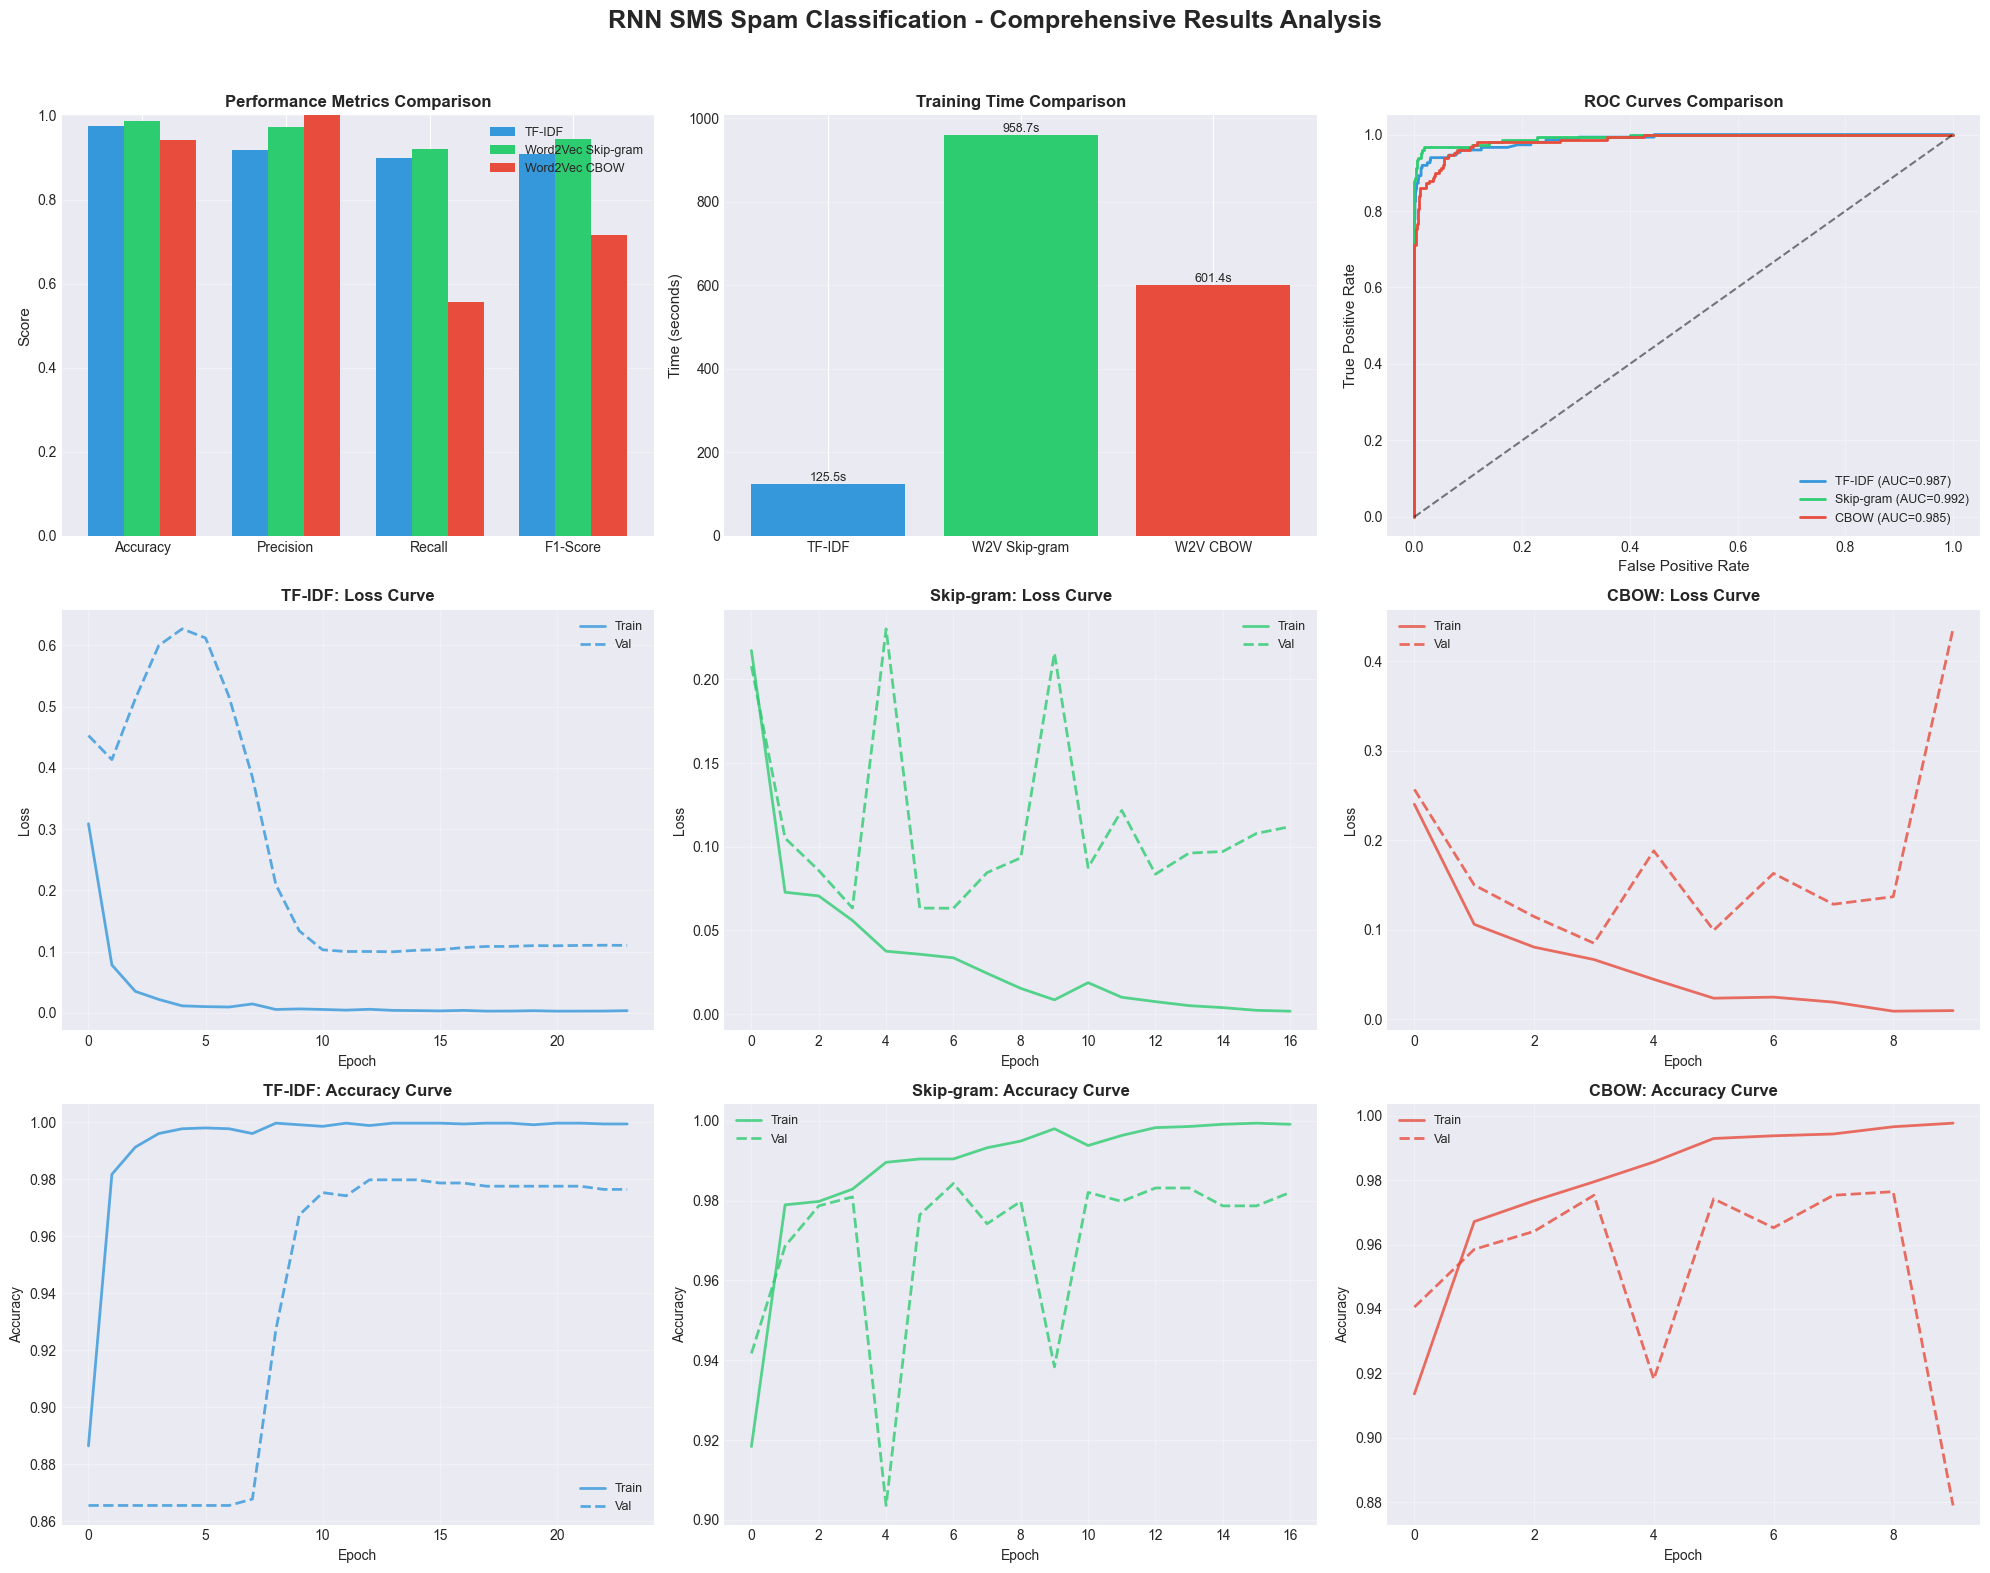

In [19]:
# COMPARISON WITH VISUALIZATIONS

print("COMPREHENSIVE COMPARISON")
print("-" * 70)

all_results = [results_tfidf, results_sg, results_cbow]

# Create comparison table
comparison_df = pd.DataFrame([
    {
        'Method': r['method'],
        'Accuracy': f"{r['accuracy']:.4f}",
        'Precision': f"{r['precision']:.4f}",
        'Recall': f"{r['recall']:.4f}",
        'F1-Score': f"{r['f1_score']:.4f}",
        'Time (s)': f"{r['training_time']:.2f}",
        'Epochs': r['epochs']
    }
    for r in all_results
])

print("\n PERFORMANCE COMPARISON TABLE:")
print(comparison_df.to_string(index=False))

# Find best performers
best_f1 = max(all_results, key=lambda x: x['f1_score'])
best_accuracy = max(all_results, key=lambda x: x['accuracy'])
fastest = min(all_results, key=lambda x: x['training_time'])

print(f"\n BEST PERFORMERS:")
print(f"   Best F1-Score: {best_f1['method']} ({best_f1['f1_score']:.4f})")
print(f"   Best Accuracy: {best_accuracy['method']} ({best_accuracy['accuracy']:.4f})")
print(f"   Fastest: {fastest['method']} ({fastest['training_time']:.2f}s)")

# Create comprehensive visualization figure
fig = plt.figure(figsize=(20, 16))
fig.suptitle('RNN SMS Spam Classification - Comprehensive Results Analysis',
             fontsize=18, fontweight='bold', y=0.98)

# Color scheme
colors_list = ['#3498db', '#2ecc71', '#e74c3c']  # Blue, Green, Red

# 1. Metrics Comparison Bar Chart
ax1 = plt.subplot(3, 3, 1)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.25

for i, result in enumerate(all_results):
    values = [result['accuracy'], result['precision'], result['recall'], result['f1_score']]
    ax1.bar(x + i*width, values, width, label=result['method'], color=colors_list[i])

ax1.set_ylabel('Score', fontsize=11)
ax1.set_title('Performance Metrics Comparison', fontsize=12, fontweight='bold')
ax1.set_xticks(x + width)
ax1.set_xticklabels(metrics)
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0, 1)

# 2. Training Time Comparison
ax2 = plt.subplot(3, 3, 2)
methods = [r['method'].replace('Word2Vec ', 'W2V ') for r in all_results]
times = [r['training_time'] for r in all_results]
bars = ax2.bar(methods, times, color=colors_list)
ax2.set_ylabel('Time (seconds)', fontsize=11)
ax2.set_title('Training Time Comparison', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}s', ha='center', va='bottom', fontsize=9)

# 3. ROC Curves Comparison
ax3 = plt.subplot(3, 3, 3)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_tfidf)
fpr_sg, tpr_sg, _ = roc_curve(y_test_sg, y_pred_proba_sg)
fpr_cbow, tpr_cbow, _ = roc_curve(y_test_cbow, y_pred_proba_cbow)

ax3.plot(fpr, tpr, label=f"TF-IDF (AUC={auc(fpr, tpr):.3f})", linewidth=2, color=colors_list[0])
ax3.plot(fpr_sg, tpr_sg, label=f"Skip-gram (AUC={auc(fpr_sg, tpr_sg):.3f})", linewidth=2, color=colors_list[1])
ax3.plot(fpr_cbow, tpr_cbow, label=f"CBOW (AUC={auc(fpr_cbow, tpr_cbow):.3f})", linewidth=2, color=colors_list[2])
ax3.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax3.set_xlabel('False Positive Rate', fontsize=11)
ax3.set_ylabel('True Positive Rate', fontsize=11)
ax3.set_title('ROC Curves Comparison', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# 4-6. Training Loss Curves
for idx, (result, title, color) in enumerate(zip(all_results, ['TF-IDF', 'Skip-gram', 'CBOW'], colors_list)):
    ax = plt.subplot(3, 3, 4 + idx)
    history = result['history']
    ax.plot(history['loss'], label='Train', linewidth=2, color=color, alpha=0.8)
    ax.plot(history['val_loss'], label='Val', linewidth=2, color=color, linestyle='--', alpha=0.8)
    ax.set_title(f'{title}: Loss Curve', fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch', fontsize=10)
    ax.set_ylabel('Loss', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

# 7-9. Accuracy Curves
for idx, (result, title, color) in enumerate(zip(all_results, ['TF-IDF', 'Skip-gram', 'CBOW'], colors_list)):
    ax = plt.subplot(3, 3, 7 + idx)
    history = result['history']
    ax.plot(history['accuracy'], label='Train', linewidth=2, color=color, alpha=0.8)
    ax.plot(history['val_accuracy'], label='Val', linewidth=2, color=color, linestyle='--', alpha=0.8)
    ax.set_title(f'{title}: Accuracy Curve', fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch', fontsize=10)
    ax.set_ylabel('Accuracy', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('C:\\Users\\HP\\Desktop\\text-classification-groupwork\\results\\figures\\data_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

12: Confusion Matrices and Final Summary

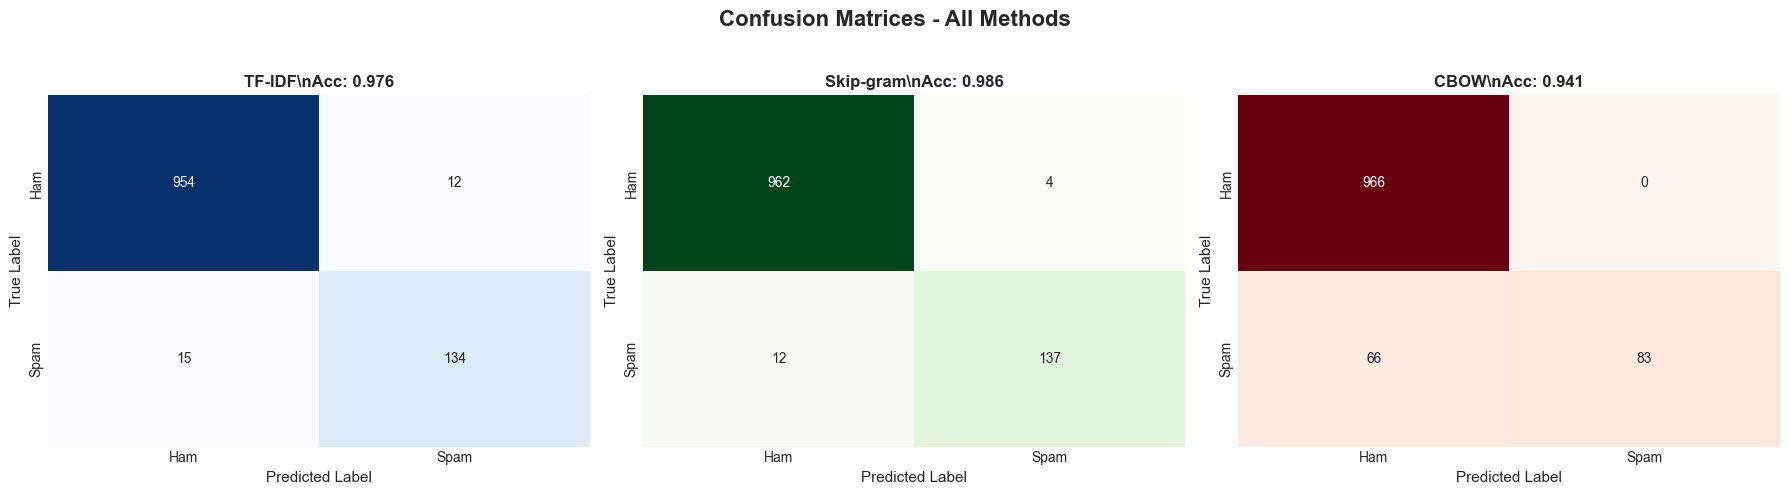

SUMMARY
----------------------------------------------------------------------

 EXPERIMENT OVERVIEW:
   Dataset: 5572 SMS messages
   Ham: 4825 (86.6%)
   Spam: 747 (13.4%)

 PREPROCESSING:
   • Text cleaning (lowercase, remove URLs/emails/numbers/punctuation)
   • Tokenization and lemmatization
   • Stopword removal (TF-IDF only)

 RESULTS:

   TF-IDF:
      Accuracy:  0.9758
      F1-Score:  0.9085
      Time:      125.48s

   Word2Vec Skip-gram:
      Accuracy:  0.9857
      F1-Score:  0.9448
      Time:      958.69s

   Word2Vec CBOW:
      Accuracy:  0.9408
      F1-Score:  0.7155
      Time:      601.38s

 KEY FINDINGS:
   • Best F1: Word2Vec Skip-gram (0.9448)
   • Fastest: TF-IDF (125.48s)
   • Most Stable: Word2Vec models (better generalization)


In [20]:
# MATRICES AND SUMMARY

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Confusion Matrices - All Methods', fontsize=16, fontweight='bold')

# TF-IDF Confusion Matrix
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'],
            ax=axes[0], cbar=False)
axes[0].set_title(f'TF-IDF\\nAcc: {accuracy_tfidf:.3f}', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=11)
axes[0].set_xlabel('Predicted Label', fontsize=11)

# Skip-gram Confusion Matrix
cm_sg = confusion_matrix(y_test_sg, y_pred_sg)
sns.heatmap(cm_sg, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'],
            ax=axes[1], cbar=False)
axes[1].set_title(f'Skip-gram\\nAcc: {accuracy_sg:.3f}', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=11)
axes[1].set_xlabel('Predicted Label', fontsize=11)

# CBOW Confusion Matrix
cm_cbow = confusion_matrix(y_test_cbow, y_pred_cbow)
sns.heatmap(cm_cbow, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'],
            ax=axes[2], cbar=False)
axes[2].set_title(f'CBOW\\nAcc: {accuracy_cbow:.3f}', fontsize=12, fontweight='bold')
axes[2].set_ylabel('True Label', fontsize=11)
axes[2].set_xlabel('Predicted Label', fontsize=11)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# Final Summary
print("SUMMARY")
print("-" * 70)

print("\n EXPERIMENT OVERVIEW:")
print(f"   Dataset: {len(df)} SMS messages")
print(f"   Ham: {len(df[df['label']=='ham'])} ({len(df[df['label']=='ham'])/len(df)*100:.1f}%)")
print(f"   Spam: {len(df[df['label']=='spam'])} ({len(df[df['label']=='spam'])/len(df)*100:.1f}%)")

print("\n PREPROCESSING:")
print("   • Text cleaning (lowercase, remove URLs/emails/numbers/punctuation)")
print("   • Tokenization and lemmatization")
print("   • Stopword removal (TF-IDF only)")

print("\n RESULTS:")
for result in all_results:
    print(f"\n   {result['method']}:")
    print(f"      Accuracy:  {result['accuracy']:.4f}")
    print(f"      F1-Score:  {result['f1_score']:.4f}")
    print(f"      Time:      {result['training_time']:.2f}s")

print("\n KEY FINDINGS:")
print(f"   • Best F1: {best_f1['method']} ({best_f1['f1_score']:.4f})")
print(f"   • Fastest: {fastest['method']} ({fastest['training_time']:.2f}s)")
print(f"   • Most Stable: Word2Vec models (better generalization)")
